## Read Data

In [60]:
import pandas as pd

df = pd.read_csv("globalterrorismdb.csv", low_memory=False)

df["datetime"] = df.apply(lambda x: pd.to_datetime("{}/{}/{}".format(x["iday"] or 1, x["imonth"] or 1, x["iyear"]), dayfirst=True, utc=True), axis=1)
df["weaptype1_txt"] = df["weaptype1_txt"].replace('Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Vehicle')

df["gname_txt"] = df["gname"]
df["gname"] = df['gname'].map({value: idx for idx, value in enumerate(df['gname'].unique())})
 
#df.head()

### Visulize History

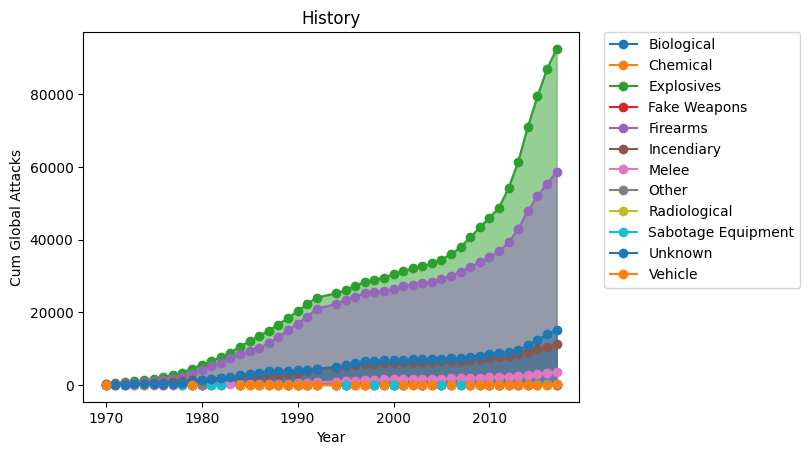

In [61]:
import matplotlib.pyplot as plt

df_history_weaptype1 = df.groupby(["iyear", "weaptype1_txt"]).size().groupby(level=1).cumsum().unstack()

plt_history_weaptype1 = df_history_weaptype1.plot(kind="line", marker="o")

for line in plt_history_weaptype1.lines:    
    color = line.get_color()    
    plt_history_weaptype1.fill_between(df_history_weaptype1.index, df_history_weaptype1[line.get_label()], color=color, alpha=0.5)

plt_history_weaptype1.set_title("History")
plt_history_weaptype1.set_xlabel("Year")
plt_history_weaptype1.set_ylabel("Cum Global Attacks")
plt_history_weaptype1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1)

plt.show()

### Visulize Attacks with corresponding fatalities and weapons

In [62]:
import json
from keplergl import KeplerGl

df_nkills_weaptype1 = df.loc[:, ["eventid", "datetime", "longitude", "latitude", "nkill", "weaptype1_txt"]]
df_nkills_weaptype1.dropna(subset=["longitude", "latitude"], inplace=True)
df_nkills_weaptype1["height"] = (df_nkills_weaptype1["nkill"].fillna(0) + 1) * 100 #scale can be adjusted
df_nkills_weaptype1["weaptype1_txt"] = df_nkills_weaptype1["weaptype1_txt"].fillna("Unknown")
#df_nkills_weaptype1.head()

map_nkills_weaptype1 = KeplerGl()
map_nkills_weaptype1.add_data(data=df_nkills_weaptype1, name='df_nkills_weaptype1')

with open("map_nkills_weaptype1_config.json", "r") as f:
    map_nkills_weaptype1.config = json.load(f)

map_nkills_weaptype1
#print(json.dumps(map_nkills_weaptype1.config, indent=4))

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\ZODWEISS\AppData\Roaming\Python\Python311\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '9dw62hh', 'type': …

### Visulize Correlation of Targets and Attackers

<Axes: >

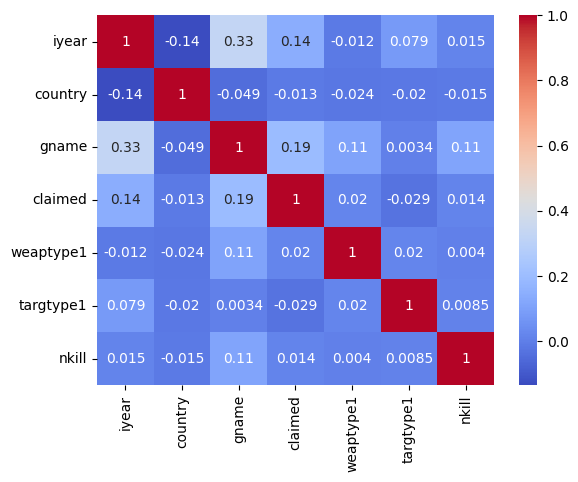

In [64]:
import seaborn as sns

df_correlation = df.loc[:, ["iyear", "country", "gname", "claimed", "weaptype1", "targtype1", "nkill"]]

sns.heatmap(df_correlation.corr(), cmap='coolwarm', annot=True)

map_